In [1]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, f1_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from skopt import BayesSearchCV
import skopt.space as space
import skopt.plots as plots
import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, LGBMRegressor

from ff_custom_scripts import *

In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='keep')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1437) (294, 1437) (530, 1437) (803, 1437)


In [3]:
meta.head(5)

,varlab,type,one_topic,dtype
new_name,,,,
f1a2,Were you present at the birth?,Binary,parenting,float64
f1a3,Have you held baby(ies)?,Binary,parenting,float64
f1a4,Will the baby(ies) have your last name?,Binary,parenting,float64
f1a5,Will your name be on the birth certificate?,Binary,parenting,float64
f1a6,Do you have other biological children?,Binary,health_and_health_behavior,float64


# Model

In [4]:
def run_model(train, target='gpa', classifier=False):

    X_train, y_train = prepare_data(train, target)
    print(X_train.shape, y_train.shape)
    
    print(X_train.shape, y_train.shape)

    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    numerical_features = cols_per_type(X_train, 'Continuous')
    print(f'N. of numerical features: {len(numerical_features)}')
    categorical_features = cols_per_type(X_train, 'Ordered Categorical')
    print(f'N. of categorical features: {len(categorical_features)}')
    binary_features = cols_per_type(X_train, 'Binary')
    print(f'N. of binary features: {len(binary_features)}')
    ordinal_features = cols_per_type(X_train, 'Unordered Categorical')
    print(f'N. of ordinal features: {len(ordinal_features)}')

    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        ('passthrough', ordinal_features),
        ('passthrough', binary_features)
    )

    search_space = {
        'regressor__learning_rate': space.Real(0.01, 0.06),
        'regressor__max_depth': space.Integer(5, 10),
    }

    if classifier:
        score = 'neg_brier_score'
        lgbm = LGBMClassifier()
        # catboost = CatBoostClassifier(
        #     eval_metric='Logloss', loss_function='Logloss', thread_count=-1,cat_features=categorical_features)
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
    else:
        # catboost = CatBoostRegressor(eval_metric='RMSE', thread_count=-1,cat_features=categorical_features)
        lgbm = LGBMRegressor()
        score = 'neg_mean_squared_error'

    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', lgbm)])

    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=2,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=32
    )

    # ytrain shape
    model.fit(X_train, y_train)

    return model


# GPA

In [5]:
gpa_model = run_model(train,target='gpa', classifier=False)

(937, 1431) (937,)
(937, 1431) (937,)
N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [6]:
# Woodcock-Johnson Test 10 standard score
#  f3b3	0.01004	How many times have you been apart for a week or more?
#  m2c3j	0.00904	How many days a week does father put child to bed?

In [7]:
score_model(gpa_model,'gpa',test,leaderboard,holdout,classifier=False)

Metric: mean_squared_error
Best CV score: 0.3953
Standard deviation of CV scores: 0.0341
Mean CV score: 0.3974
Test MSE: 0.4196
Test R2: 0.0781
Leaderboard MSE: 0.4499
Leaderboard R2: -0.1517
Holdout MSE: 0.4732
Holdout R2: -0.1209


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


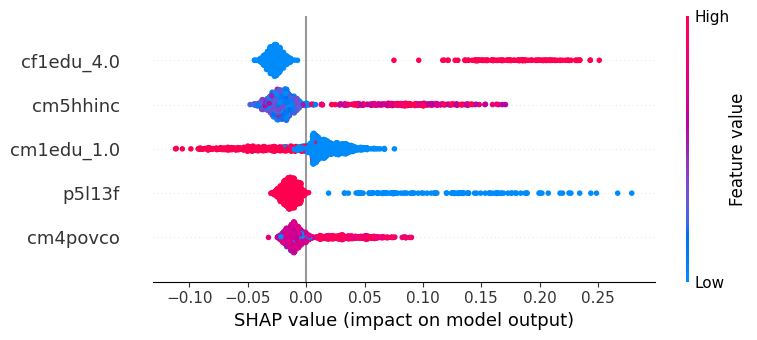

{("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'cm4povco',
 ('L13F. Gifted and talented program',): 'p5l13f',
 (): 'cf1edu_4.0',
 ("Constructed - Mother's Household income (with imputed values)",): 'cm5hhinc'}

In [8]:
shap_show(gpa_model, alldata, target='gpa')

# Material Hardship

In [9]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

(1167, 1431) (1167,)
(1167, 1431) (1167,)
N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [10]:
model_materialHardship.best_params_

OrderedDict([('regressor__learning_rate', 0.04216976237837121),
             ('regressor__max_depth', 9)])

In [11]:
score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)


Metric: mean_squared_error
Best CV score: 0.0199
Standard deviation of CV scores: 0.0019
Mean CV score: 0.0200
Test MSE: 0.0237
Test R2: 0.1329
Leaderboard MSE: 0.0336
Leaderboard R2: -0.1757
Holdout MSE: 0.0315
Holdout R2: -0.2910


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


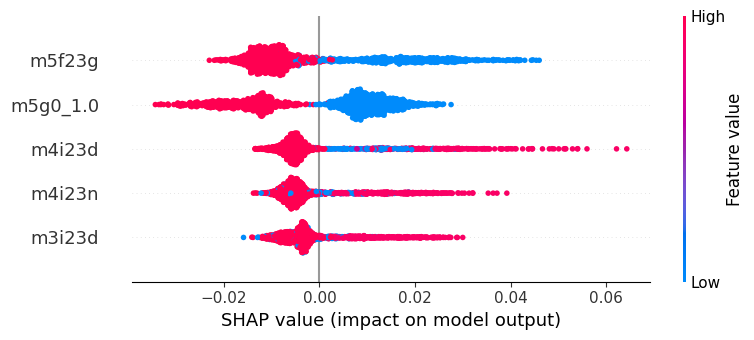

{('In past year, did you not pay full gas/oil/electricity bill?',): 'm3i23d',
 ("In past year, phone service disconnected b/c wasn't enough money?",): 'm4i23n',
 ("In past year, did not pay full amt rent/mortgage payments b/c wasn't enough",): 'm4i23d',
 (): 'm5g0_1.0',
 ('F23G. Borrowed money from friends/family to help pay bills in past 12 months',): 'm5f23g'}

In [12]:
shap_show(model_materialHardship, alldata, target='materialHardship')


# Grit


In [13]:
model_grit = run_model(train,target='grit', classifier=False)

(1136, 1431) (1136,)
(1136, 1431) (1136,)
N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [14]:
# Value 2 for “(He/she) stares blankly.”
#  hv4r10a_3_1	0.01520	Value 1 for “Any hazardous condition 3: broken glass”
#  hv5_wj9raw	0.00946	Woodcock-Johnson Test 9 raw score

In [15]:
model_grit.best_params_

OrderedDict([('regressor__learning_rate', 0.013587610784167528),
             ('regressor__max_depth', 10)])

In [16]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Metric: mean_squared_error
Best CV score: 0.2314
Standard deviation of CV scores: 0.0279
Mean CV score: 0.2328
Test MSE: 0.2336
Test R2: 0.0079
Leaderboard MSE: 0.2363
Leaderboard R2: -0.0756
Holdout MSE: 0.2563
Holdout R2: -0.0730


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


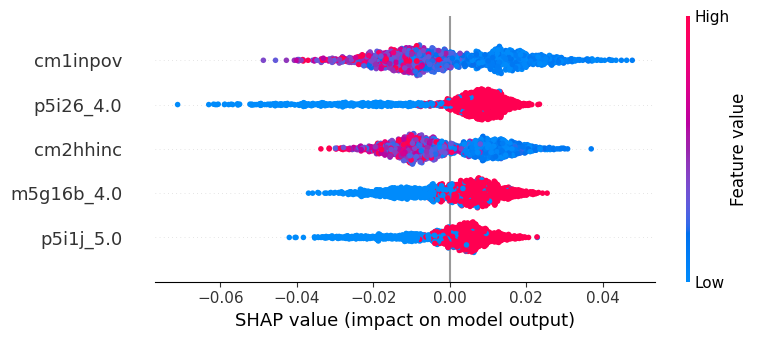

{(): 'p5i26_4.0',
 ('Constructed - Household income (with imputed values)',): 'cm2hhinc',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'cm1inpov'}

In [17]:
shap_show(model_grit, alldata, target='grit')

# Eviction

In [18]:
model_eviction = run_model(train,target='eviction', classifier=True)

(1168, 1431) (1168,)
(1168, 1431) (1168,)
N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [19]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout=None, classifier=True)

Test Brier: 0.0481
Test F1: 0.0000
Leaderboard Brier: 0.0660
Leaderboard F1: 0.0541


In [20]:
# Value “yes” for “Telephone service disconnected because wasn’t enough money in past 12 months.”
#  m5f23c_1	0.05842	Value “yes” for “Did not pay full amount of rent/mortgage payments in past 12 months.”
#  m3i4	0.02062	How much rent do you pay each month?

In [21]:
# shap_show(model_eviction, alldata, target='eviction')

In [22]:
# top5 = ['m5f23k','p3m39','m5i3c']

# meta[meta.index.isin(top5)].varlab.values

# jobTraining

In [23]:
# Value “yes” for “In the last 2 years, have you taken any classes to improve your job skills?”
#  m5i1_1	0.06355	Value “yes” for “You are currently attending any school/trainings program/classes.”
#  m5i3b_1	0.06355	Value “yes” for “You have taken classes to improve job skills since last interview.”

In [24]:
model_job = run_model(train,target='jobTraining', classifier=True)

(1169, 1431) (1169,)
(1169, 1431) (1169,)
N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [25]:
score_model(model_job, 'jobTraining', test, leaderboard, holdout=None, classifier=True)

Test Brier: 0.2911
Test F1: 0.3972
Leaderboard Brier: 0.3623
Leaderboard F1: 0.2131


In [26]:
# shap_show(model_job, alldata, target='jobTraining',n=5)

# Layoff

In [27]:
# mount of money spent eating out in last month
#  m3i0q	0.01678	How important is it to serve in the military when at war?
#  f5i13	0.01678	How much you earn in that job, before taxes

In [28]:
model_layoff = run_model(train, target='layoff', classifier=True)

(1026, 1431) (1026,)
(1026, 1431) (1026,)
N. of numerical features: 135
N. of categorical features: 469
N. of binary features: 692
N. of ordinal features: 135


In [29]:
model_layoff.best_params_

OrderedDict([('regressor__learning_rate', 0.013587610784167528),
             ('regressor__max_depth', 10),
             ('regressor__scale_pos_weight', 12)])

In [30]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout, classifier=True)

Test Brier: 0.2749
Test F1: 0.2247
Leaderboard Brier: 0.2887
Leaderboard F1: 0.1639
Holdout Brier: 0.2802


In [31]:
# shap_show(model_layoff, alldata, target='layoff')